# GEOG696C Spatiotemporal Data Analytics: Term Project
## calcMCA_FIA_precip.ipynb
This script performs an MCA between the FIA and precip datasets.

In [1]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import math
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import rioxarray as rx
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import scipy as sp
import cartopy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

In [2]:
# Set the root path
# rootPath = Path('/media/mule/Projects/NASA/NIP/Data')
rootPath = Path('C:/Users/alexsaunders/Documents/01_uoa/01_study/2023/geog696c/project/data')

In [3]:
font_dirs = ['C:/users/alexsaunders/appdata/local/microsoft/windows/fonts']
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    mpl.font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Work Sans'

## 1) Load the precip and FIA data

In [17]:
chirpsPath=rootPath/'chirps'
rawPath=chirpsPath/'raw'
# Load in from netcdf
precip = xr.open_dataarray(chirpsPath/'xr/precip.nc')
precip

<xarray.DataArray (time: 1584, lat: 120, lon: 93)>
[17677440 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-06 ... 2022-12-26
  * lat      (lat) float64 26.62 26.57 26.52 26.47 ... 20.82 20.77 20.72 20.67
  * lon      (lon) float64 88.03 88.08 88.13 88.18 ... 92.48 92.53 92.58 92.63

In [24]:
FIAPath = rootPath/'pixelFIA/xr/'
FIA = xr.open_dataarray(FIAPath/'pixelFIA.nc')
FIA = FIA.where(FIA!=-9999, np.nan)
FIA

<xarray.DataArray (lat: 1346, lon: 1040, time: 985)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat      (lat) float64 26.63 26.63 26.62 26.62 ... 20.61 20.6 20.6 20.59
  * lon      (lon) float64 88.01 88.01 88.02 88.02 ... 92.66 92.67 92.67 92.68
  * time     (time) datetime64[ns] 2001-06-13 2001-06-29 ... 2022-12-30

## 2) Pre-process data to monsoon max

In [19]:
# Function to resample and get monthly max, annual max and monsoon max
def getMonthlyAnnualMax(xrData):
    # Use resample to get monthly
    MonthlyMax = xrData.resample(time='1M', skipna=True).max(dim='time')
    # Use rolling to get annual max
    Monthly_ = MonthlyMax.rolling(time = 12).max(skipna=True)
    AnnualMax = Monthly_.where(Monthly_.time.dt.month == 12, drop=True)

    # Drop 2001 since it is an incomplete year, with data starting in June
    AnnualMax = AnnualMax.drop_isel(time=0)

    # Use rolling to get monsoon annual max - monsoon months are June-October inclusive i.e. 5 months
    Monthly_ = MonthlyMax.rolling(time = 5).max(skipna=True)
    MonsoonMax = Monthly_.where(Monthly_.time.dt.month == 10, drop=True)
    
    return MonthlyMax, AnnualMax, MonsoonMax

In [20]:
precipMonthlyMax, precipAnnualMax, precipMonsoonMax = getMonthlyAnnualMax(precip)

In [25]:
FIAMonthlyMax, FIAAnnualMax, FIAMonsoonMax = getMonthlyAnnualMax(FIA)

In [31]:
# Change time to first dimension
FIAMonsoonMax=FIAMonsoonMax.transpose("time", "lat", "lon")

### Downsample FIA to lower resolution to be able to compute the cross covar matrix

Original resolution of FIA is 500 m.

Target resolution same as CHIRPS i.e. 5 km, so 10x scale factor

In [49]:
print(FIAMonsoonMax.shape[1] / precipMonsoonMax.shape[1], FIAMonsoonMax.shape[2] / precipMonsoonMax.shape[2])

11.216666666666667 11.182795698924732


In [50]:
resFactor=11

In [51]:
FIAMonsoonMaxCoarse = FIAMonsoonMax.coarsen(lat=resFactor, boundary='trim').mean().coarsen(lon=resFactor, boundary='trim').mean()

In [54]:
print(precipMonsoonMax.shape, FIAMonsoonMaxCoarse.shape)

(22, 120, 93) (22, 122, 94)


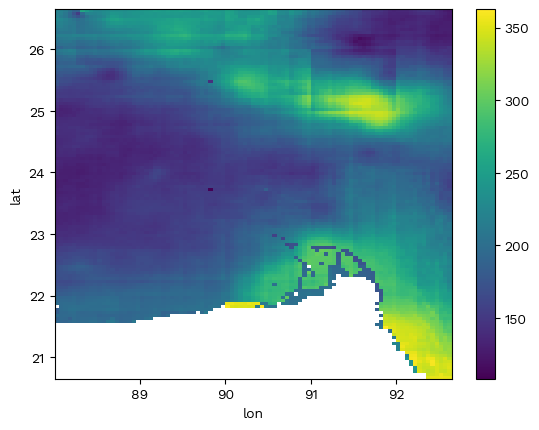

In [61]:
precipMonsoonMax.mean(dim="time").plot()

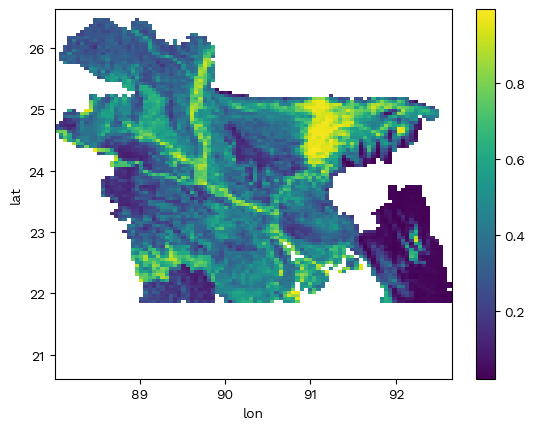

In [59]:
FIAMonsoonMaxCoarse.mean(dim="time").plot()

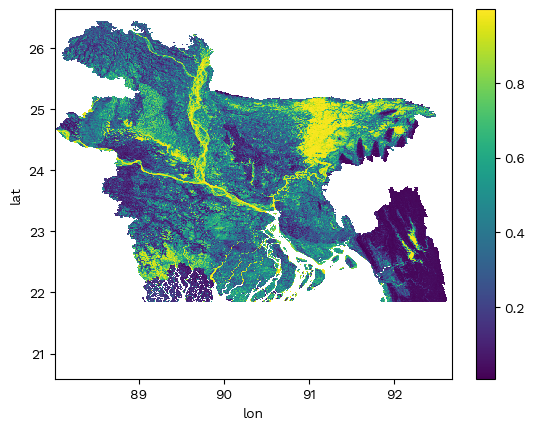

In [60]:
FIAMonsoonMax.mean(dim="time").plot()

### Reshape and normalize

In [32]:
# Function to reshape, remove locs with missing values
def reshape(data):
    ntime, nrow, ncol = data.shape
    nloc=nrow*ncol
    dataNew = np.array(data).reshape(ntime, nloc)
    print('Shape before removing data with missing vals', dataNew.shape)
    # Remove locs with missing values i.e. only keep pixels which have zero NA values at all timesteps
    noMissing = ~np.isnan(dataNew).any(axis=0)
    dataNew = dataNew[:,noMissing]
    print('Shape after removing data with missing vals', dataNew.shape)
    return dataNew, ntime, nrow, ncol, nloc, noMissing

# Function to normalize - subtract mean and divide by standard deviation at each pixel
def normalize(data):
    anom = (data - data.mean(axis=0)) / data.std(axis=0)
    print(anom[0,:])
    return anom

In [33]:
precipMonsoonMax2D, ntimeP, nrowP, ncolP, nlocP, noMissingP = reshape(precipMonsoonMax)
precipMonsoonMaxAnom = normalize(precipMonsoonMax2D)

Shape before removing data with missing vals (22, 11160)
Shape after removing data with missing vals (22, 9317)
[ 0.55329358  0.55739635  0.49202177 ... -0.29978521 -0.14219201
  0.02005767]


In [55]:
FIAMonsoonMax2D, ntimeF, nrowF, ncolF, nlocF, noMissingF = reshape(FIAMonsoonMaxCoarse)
FIAMonsoonMaxAnom = normalize(FIAMonsoonMax2D)

Shape before removing data with missing vals (22, 11468)
Shape after removing data with missing vals (22, 5362)
[0.80671164 0.59960732 1.29757597 ... 4.44113025 4.39456185 4.16354272]


## 3) Perform MCA

### Run SVD on cross covariance matrix

In [58]:
# Create cross covariance matrix
C = (precipMonsoonMaxAnom.T @ FIAMonsoonMaxAnom)/(ntimeP-1)
print(C.shape)

(9317, 5362)


In [63]:
# Function to perform MCA using cross covar matrix
def runSVDforMCA(C, k, datax, datay):
    U, S, Vt = sp.sparse.linalg.svds(C, k=k)
    # Sort the eigenmodes
    sort_index = np.argsort(S)[::-1]
    S = S[sort_index]
    U = U[:,sort_index]
    V = Vt.T[:,sort_index]
    # Create the PCs time series
    pcsx = datax @ U
    pcsy = datay @ V
    print('PCs for x',pcsx.shape)
    print('PCs for y',pcsy.shape)
    return pcsx, pcsy

In [65]:
k=21
pcsPrecip, pcsFIA = runSVDforMCA(C, k, precipMonsoonMaxAnom, FIAMonsoonMaxAnom)

PCs for x (22, 21)
PCs for y (22, 21)


In [107]:
# Put PCs in data arrays
pcsP = xr.DataArray(pcsPrecip, coords={'time': precipMonsoonMax.time, 'mode': np.arange(0,k)}, dims=["time","mode"],name="PrecipPC")
pcsF = xr.DataArray(pcsFIA, coords={'time': FIAMonsoonMaxCoarse.time, 'mode': np.arange(0,k)}, dims=["time","mode"],name="FIAPC")

### Calculate homogeneous and hetereogenous correlation fields

In [109]:
homP = xr.corr(pcsP, precipMonsoonMax, dim="time")
homF = xr.corr(pcsF, FIAMonsoonMaxCoarse, dim="time")

hetP = xr.corr(pcsP, FIAMonsoonMaxCoarse, dim="time")
hetF = xr.corr(pcsF, precipMonsoonMax, dim="time")

C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of f

In [110]:
# Put mode as the third dimension
homP=homP.transpose("lat", "lon", "mode")
homF=homF.transpose("lat", "lon", "mode")
hetP=hetP.transpose("lat", "lon", "mode")
hetF=hetF.transpose("lat", "lon", "mode")

### Plot the homogeneous correlations fields

In [111]:
dataToPlot=[homP,homF,homP,homF]
modesToPlot=[0,0,1,1]
namesToPlot=['Precipitation', 'Inundation', 'Precipitation', 'Inundation']

4 subplots:

* Mode 1 Homogeneous Precip, Mode 1 Homegenous FIA

* Mode 2 Homogeneous Precip, Mode 2 Homegenous FIA

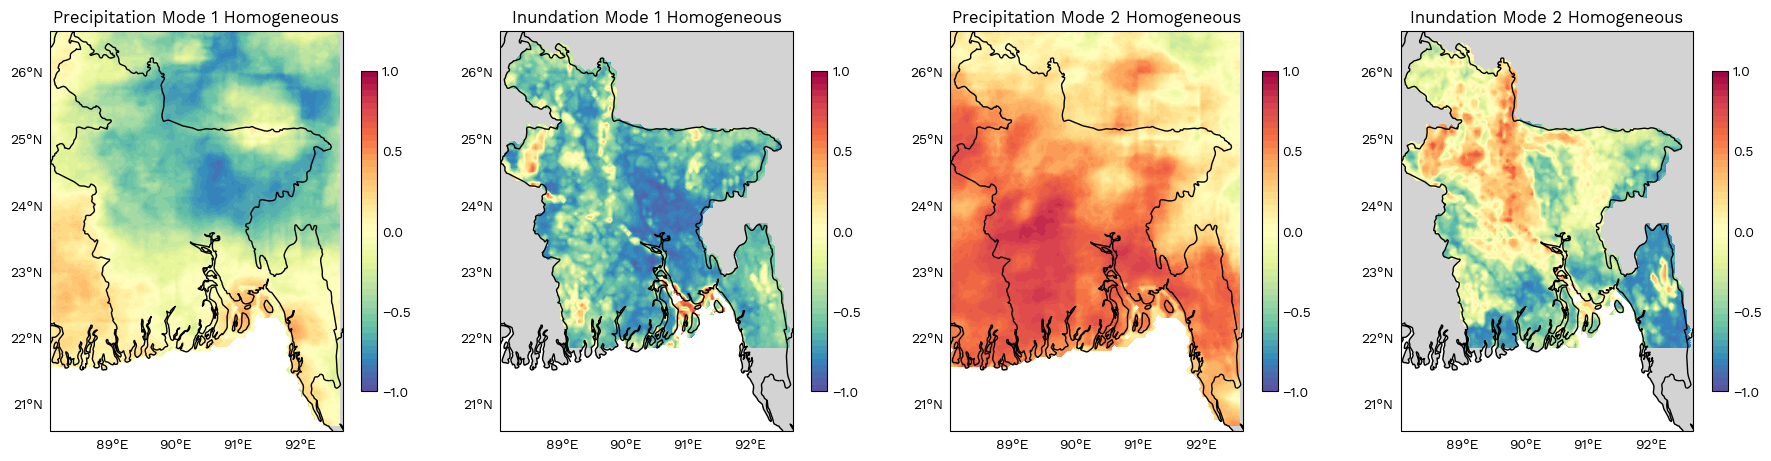

In [121]:
# vmin, vmax, nlevels, nlevelsCbar = -0.03, 0.03, 51, 7
# vmin, vmax, nlevels, nlevelsCbar = -0.003, 0.003, 51, 7
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 3
cmap='Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
nToPlot=4
ncolsToPlot=4
colSize=4.5

fig, axes = plt.subplots(math.ceil(nToPlot/ncolsToPlot), ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*(math.ceil(nToPlot/ncolsToPlot))), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=90)})
# fig.suptitle('Homogenous correlations, precip')

for i, ax in enumerate(axes.ravel()[:nToPlot]):#
    
    plotData=dataToPlot[i][:,:,modesToPlot[i]]
    plotCoords=dataToPlot[i]
    ax.set_title('{0} Mode {1} Homogeneous'.format(namesToPlot[i],modesToPlot[i]+1))#, fontsize=16)
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent([FIA.lon.min().values, FIA.lon.max().values, FIA.lat.min().values, FIA.lat.max().values], crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    eofPlot = ax.contourf(plotCoords.lon, plotCoords.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels) 
    cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar),
                      extend='both', shrink=0.8)
    # cb1.set_label('Correlation', rotation=270) 
    cb1.ax.tick_params(size=0)
    
    # if i>=EOFsToPlot:
    #     ax.remove()
    
plt.show()

### Plot the heterogenous correlations fields

In [122]:
dataToPlot=[hetP,hetF,hetP,hetF]
modesToPlot=[0,0,1,1]
namesToPlot=['Precipitation', 'Inundation', 'Precipitation', 'Inundation']

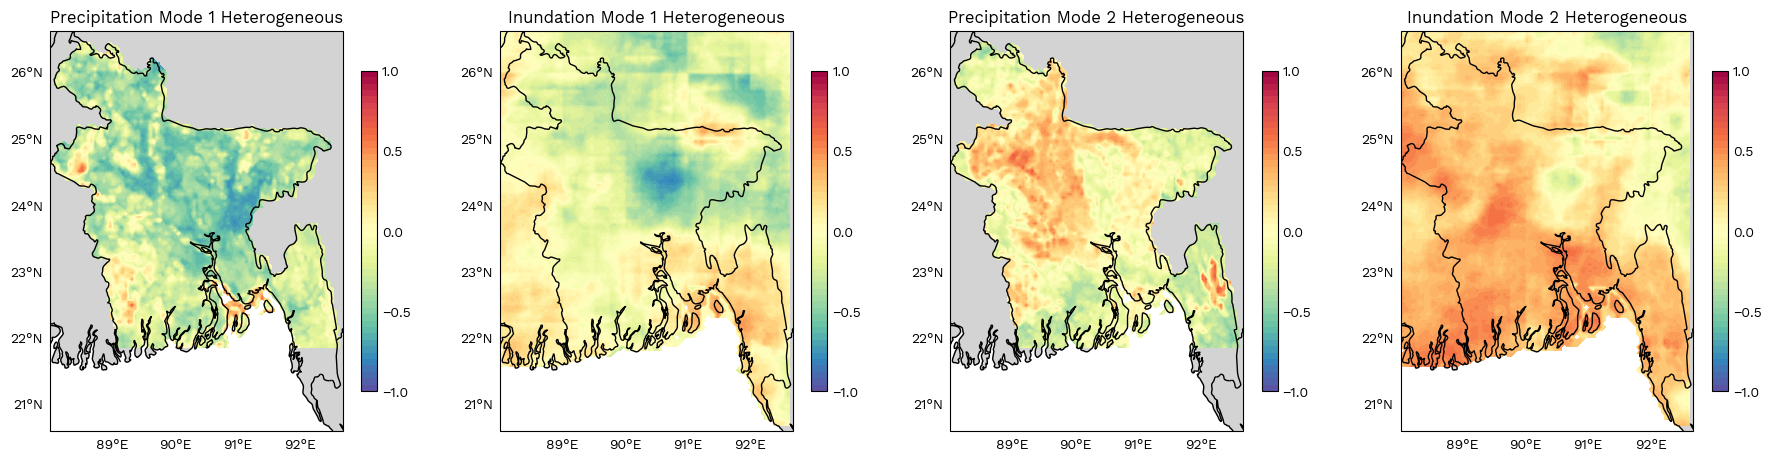

In [124]:
# vmin, vmax, nlevels, nlevelsCbar = -0.03, 0.03, 51, 7
# vmin, vmax, nlevels, nlevelsCbar = -0.003, 0.003, 51, 7
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
cmap='Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
nToPlot=4
ncolsToPlot=4
colSize=4.5

fig, axes = plt.subplots(math.ceil(nToPlot/ncolsToPlot), ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*(math.ceil(nToPlot/ncolsToPlot))), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=90)})
# fig.suptitle('Homogenous correlations, precip')

for i, ax in enumerate(axes.ravel()[:nToPlot]):#
    
    plotData=dataToPlot[i][:,:,modesToPlot[i]]
    plotCoords=dataToPlot[i]
    ax.set_title('{0} Mode {1} Heterogeneous'.format(namesToPlot[i],modesToPlot[i]+1))#, fontsize=16)
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent([FIA.lon.min().values, FIA.lon.max().values, FIA.lat.min().values, FIA.lat.max().values], crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    eofPlot = ax.contourf(plotCoords.lon, plotCoords.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels) 
    cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar),
                      extend='both', shrink=0.8)
    # cb1.set_label('Correlation', rotation=270) 
    cb1.ax.tick_params(size=0)
    
    # if i>=EOFsToPlot:
    #     ax.remove()
    
plt.show()